In [1]:
import sys
import os
sys.path.append('..')
sys.path.append('../failure_directions')
import torch
import torchvision
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


import failure_directions.src.svm_utils as svm_utils
import failure_directions.src.visualization_utils as viz_utils
import failure_directions.src.ds_utils as ds_utils
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from failure_directions.src.label_maps import CLASS_DICT
import pickle as pkl
from torchvision.datasets.folder import pil_loader


cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])
print(cifar_label_list)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [2]:
sns.set()
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)


In [36]:
#Load SVM Model
beton_root = "/mnt/cfs/projects/correlated_errors/betons"
experiment_root = "/mnt/cfs/projects/correlated_errors/experiments/cifar/cifar_0.25"

svm_name = "svm_cifar_0.25_unlabeled_normalized"
name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}.pt") # SVM output file
svm_model_name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}_model.pkl") # SVM output file
model_root = os.path.join(experiment_root, "models")
model_ckpt = os.path.join(model_root, "cifar10_0.25_unlabeled/version_0/checkpoints/checkpoint_last.pt")
loss_upweight_root = os.path.join(experiment_root, "loss_vec_files")
subset_root = os.path.join(experiment_root, "subset_index_files")

%cd ../failure_directions
processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, get_unlabeled=True, batch_size=10)
%cd ../analysis_nbs
svm_model = processor._build_model(model_ckpt)


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
-----------train_metrics--------------
{'Confusion Matrix': array([[ 439,  192],
       [3195, 6174]]),
 'Model Accuracy': 0.9369,
 'SVM Accuracy': 0.661300003528595,
 'SVM Balanced Accuracy': 0.6773514151573181}
-----------val_metrics--------------
{'Confusion Matrix': array([[1593,  415],
       [1713, 6279]]),
 'Model Accuracy': 0.7992,
 'SVM Accuracy': 0.7871999740600586,
 'SVM Balanced Accuracy': 0.7894936800003052}
-----------test_metrics--------------
{'Confusion Matrix': array([[1346,  749],
       [2007, 5898]]),
 'Model Accuracy': 0.7905,
 'SVM Accuracy': 0.724399983882904,
 'SVM Balanced Accuracy': 0.6942960917949677}
-----------unlabeled_metrics--------------
{'Confusion Matrix': array([[ 3972,  2185],
       [ 5945, 17898]]),
 'Model Accuracy': 0.7947666666666666,
 'SVM Accuracy': 0.7289999723434448,
 'SVM Balanced Accuracy': 0.6978899836540222}
Using default os_cache: False
Using default quasi_random: True
Us

100%|██████████| 1000/1000 [00:06<00:00, 159.57it/s]


Accuracy 0.9383000135421753


100%|██████████| 1000/1000 [00:04<00:00, 215.93it/s]


Accuracy 0.7991999983787537


100%|██████████| 1000/1000 [00:04<00:00, 220.43it/s]


Accuracy 0.7904999852180481


100%|██████████| 3000/3000 [00:11<00:00, 256.85it/s]


Accuracy 0.7947333455085754
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs
{'training_args': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}, 'iters_per_epoch': 19}, 'epoch': 34, 'training_metrics': {'loss': 0.17487808826722598, 'acc': 0.9425370065789473}, 'val_metrics': {'loss': 0.6609623561382294, 'acc': 0.7992000002861023}}


In [7]:
import torchvision.transforms as transforms
import torchvision
from failure_directions.src.decoders_and_transforms import PyTranslate, PyCutOut
hparams = processor.hparams

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    PyTranslate(2),
    PyCutOut(4, fill_color),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage(), transforms.Resize((224, 224))])
resize_base_transform = transforms.Compose([base_transform, transforms.Resize((32, 32))])
resize_train_transform = transforms.Compose([train_transform, transforms.Resize((32, 32))])

In [8]:
from omegaconf import OmegaConf
sys.path.append("/mnt/cfs/home/saachij/src/stable-diffusion2/stable-diffusion")
from scripts.txt2img import load_model_from_config, check_safety

In [9]:
config_path = "/mnt/cfs/home/saachij/src/stable-diffusion2/stable-diffusion/configs/stable-diffusion/v1-inference.yaml"
ldm_ckpt = "/mnt/cfs/home/saachij/src/stable-diffusion2/stable-diffusion/models/ldm/stable-diffusion-v1/model.ckpt"
ldm_config = OmegaConf.load(config_path)
ldm_model = load_model_from_config(ldm_config, ldm_ckpt)
ldm_model = ldm_model.eval().cuda()

Loading model from /mnt/cfs/home/saachij/src/stable-diffusion2/stable-diffusion/models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.14.layer_norm1.bias', 'vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.4.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.12.layer_norm2.bias', 'vision_model.encoder.layers.21.mlp.fc2.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.weight', 'vision_model.embeddings.patch_embedding.weight', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.14.mlp.fc2.bias', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.layer_norm1.

In [37]:
import PIL

def load_img(img):
    image = img.convert("RGB")
    w, h = 256, 256
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

def convert_batch(imgs):
    return torch.cat([load_img(TOIMAGE(img)) for img in imgs])

In [50]:
feats = {'val': [], 'test': []}
out_shape = None
for split in ['val', 'test']:
    for b in tqdm(processor.loaders['val']):
        ldm_batch = convert_batch(b[0]).cuda()
        with torch.no_grad():
            out = ldm_model.first_stage_model.encode(ldm_batch).mean
            out_shape = out.shape
            out = out.reshape(out_shape[0], -1)
            feats[split].append(out.cpu())
    feats[split] = torch.cat(feats[split])

100%|██████████| 1000/1000 [01:37<00:00, 10.31it/s]


In [39]:
val_gts, val_preds = processor.run_dict['val']['ys'], processor.run_dict['val']['preds']


In [64]:
f = feats['test'].reshape(-1, *out_shape[1:])
f = f/torch.linalg.norm(f, dim=1, keepdims=True)

In [73]:
feats['val'].reshape(-1, *out_shape[1:])

torch.Size([10000, 4, 32, 32])

In [71]:
out_shape

torch.Size([10, 4, 32, 32])

In [75]:
svm_fitter = failure_directions.SVMFitter()
svm_fitter.set_preprocess()


cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=feats['val']))
test_ys = processor.run_dict['test']['ys']
test_latents = feats['test']
big_clip_dv = svm_fitter.predict(ys=test_ys, latents=prep_latents(test_latents), compute_metrics=False)[1]
svm_fitter.export(f"big_cifar_svm_{idx}.pt")


No whitening


100%|██████████| 10/10 [03:46<00:00, 22.63s/it]
../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


In [76]:
feats['val'].shape

torch.Size([10000, 4096])

In [77]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']

---


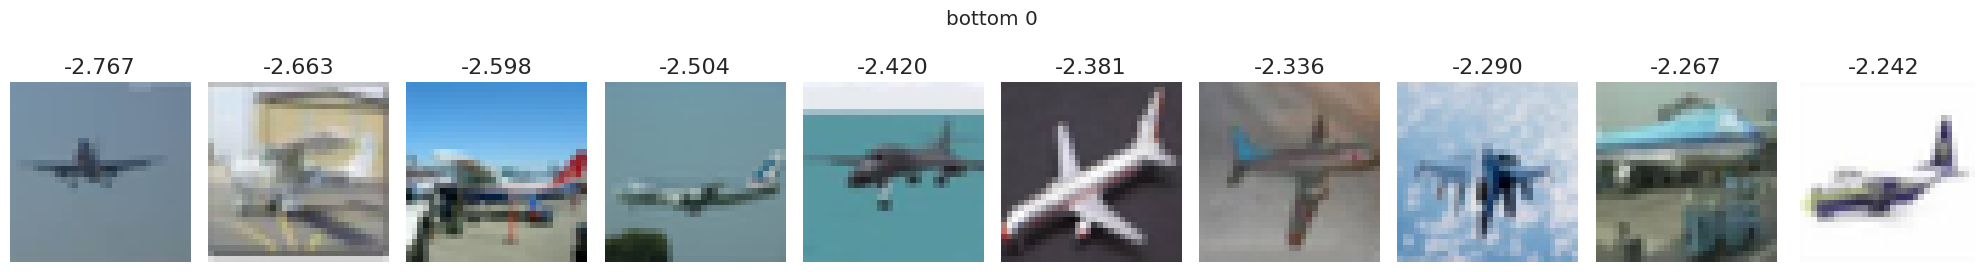

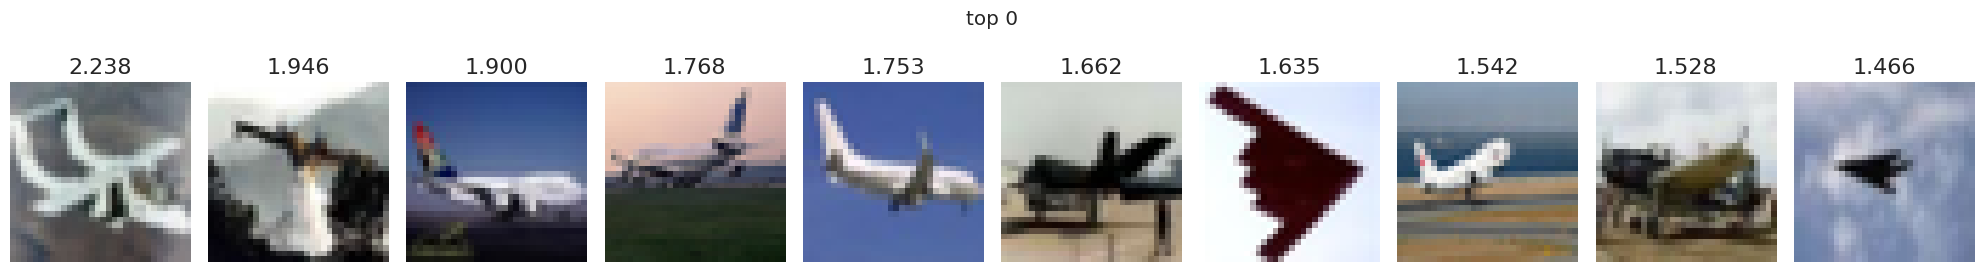



---


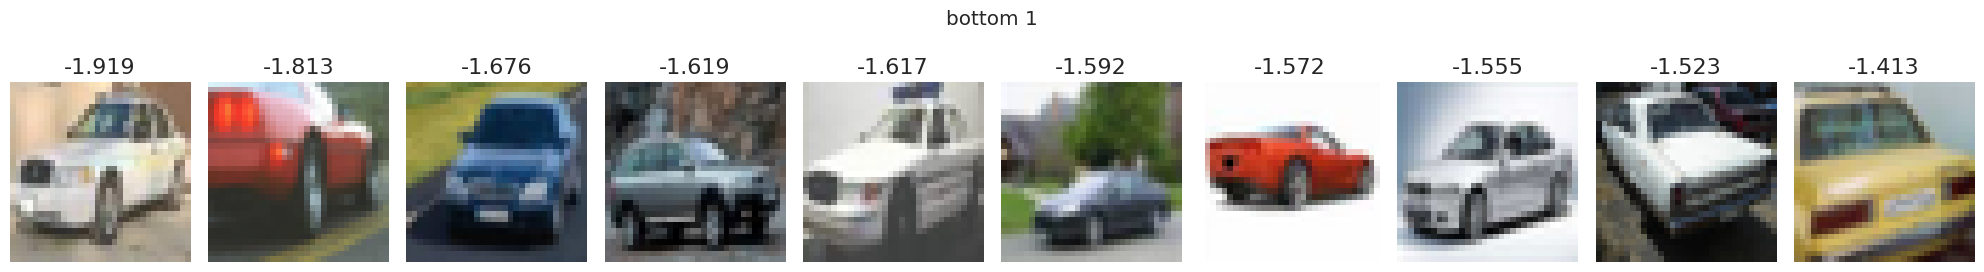

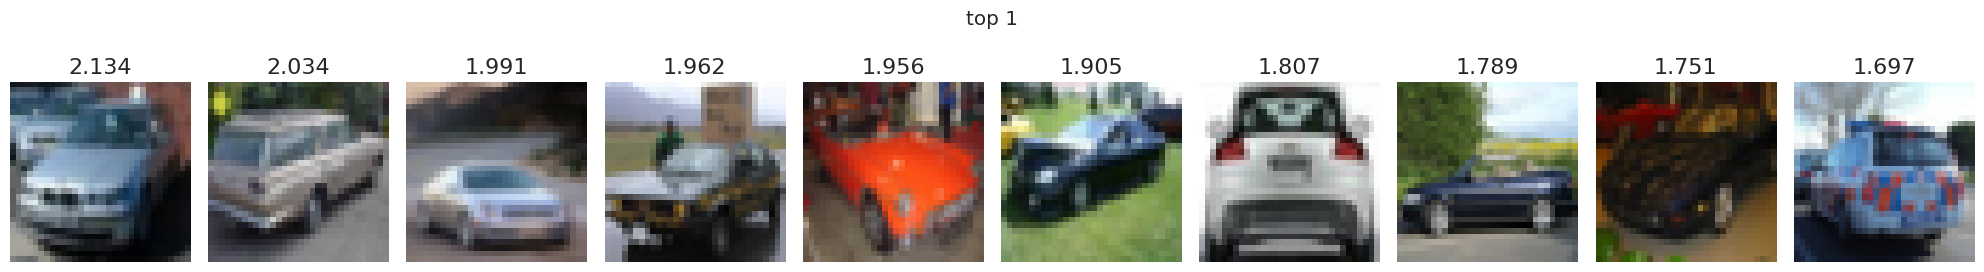



---


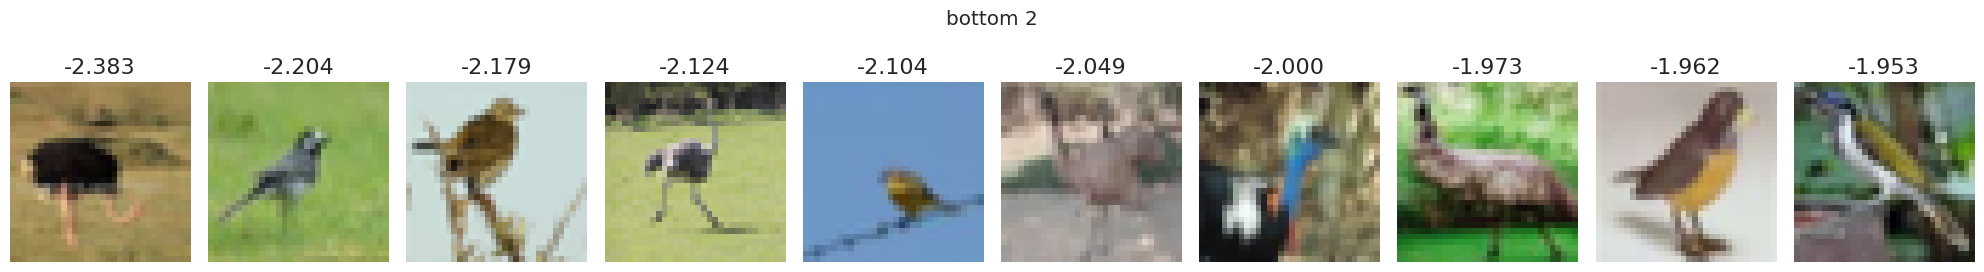

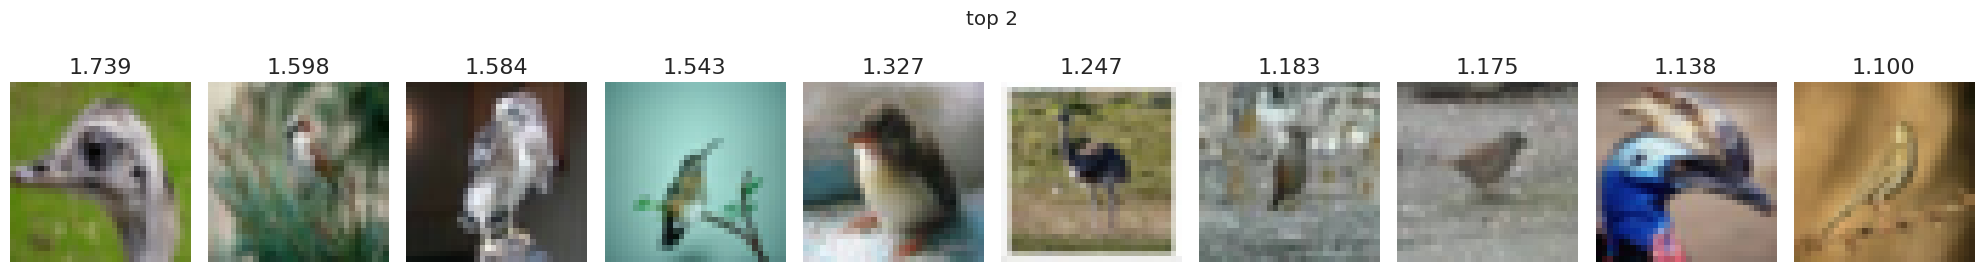



---


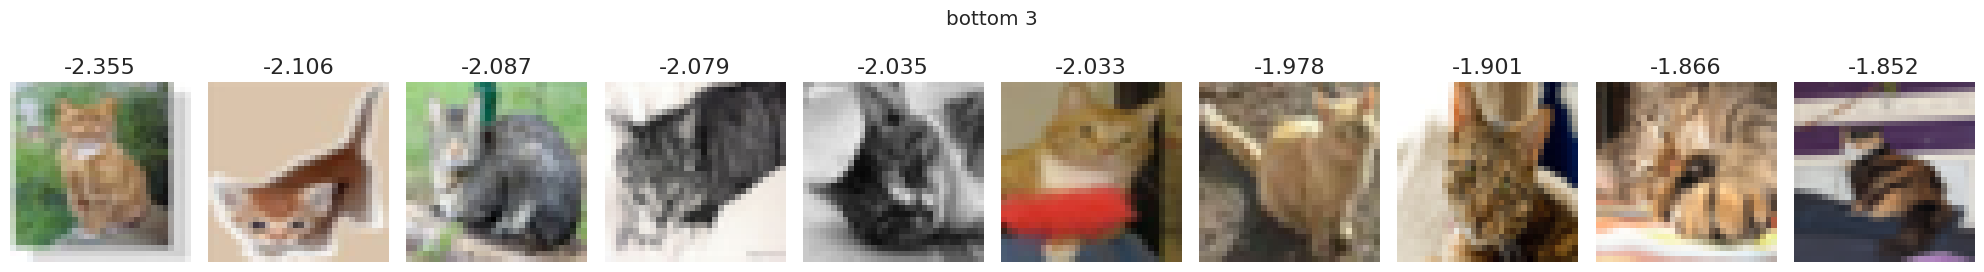

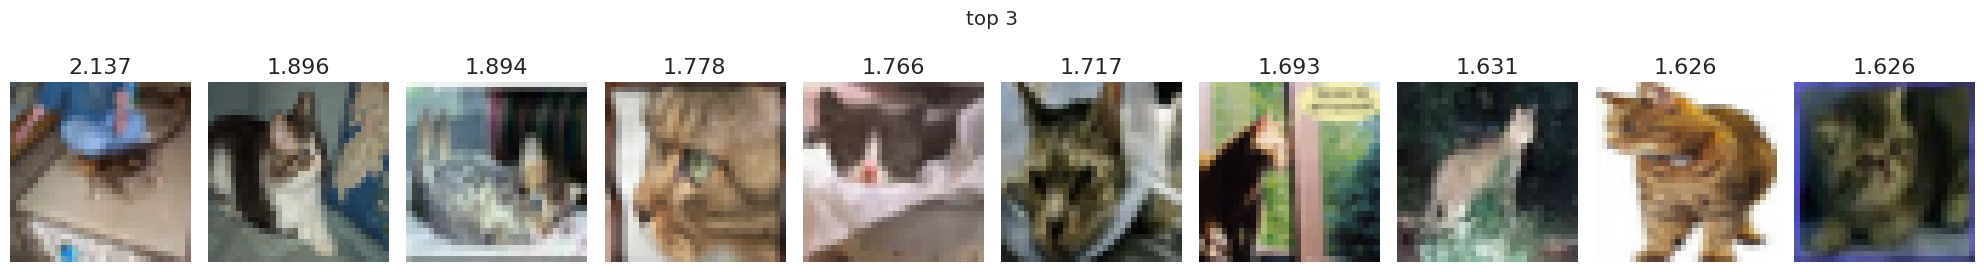



---


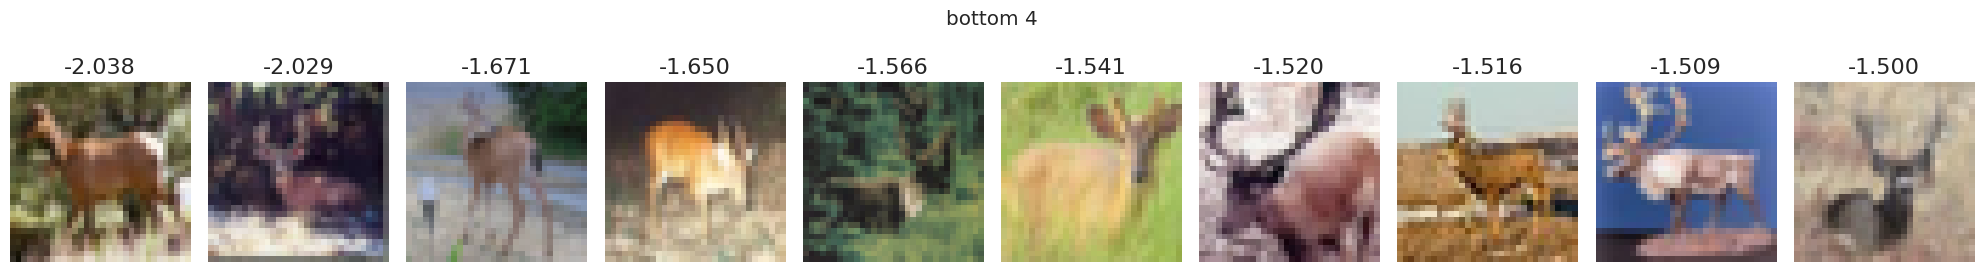

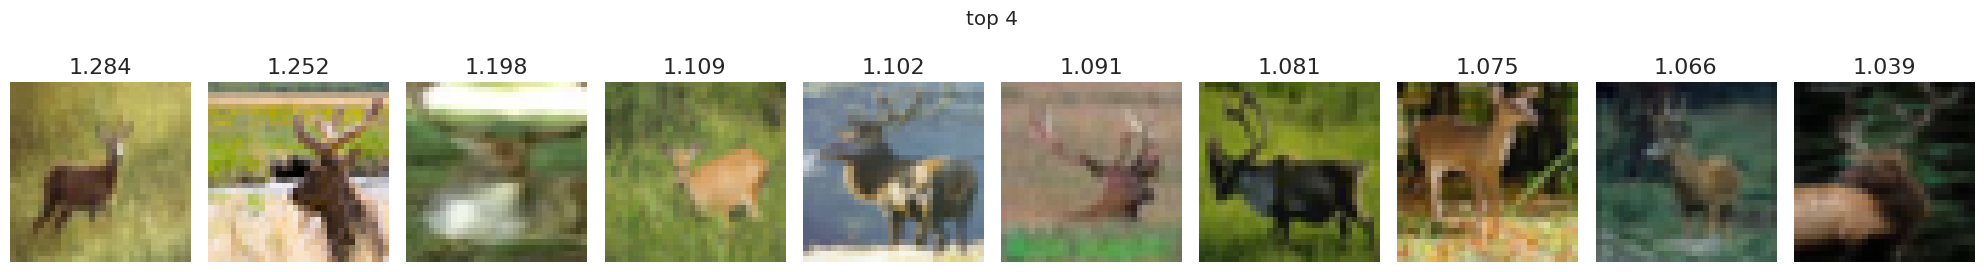



---


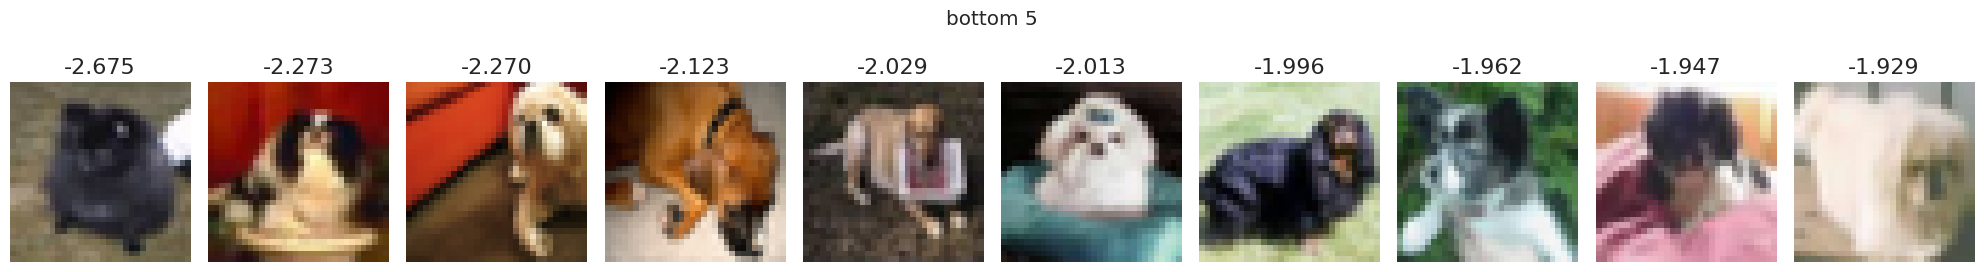

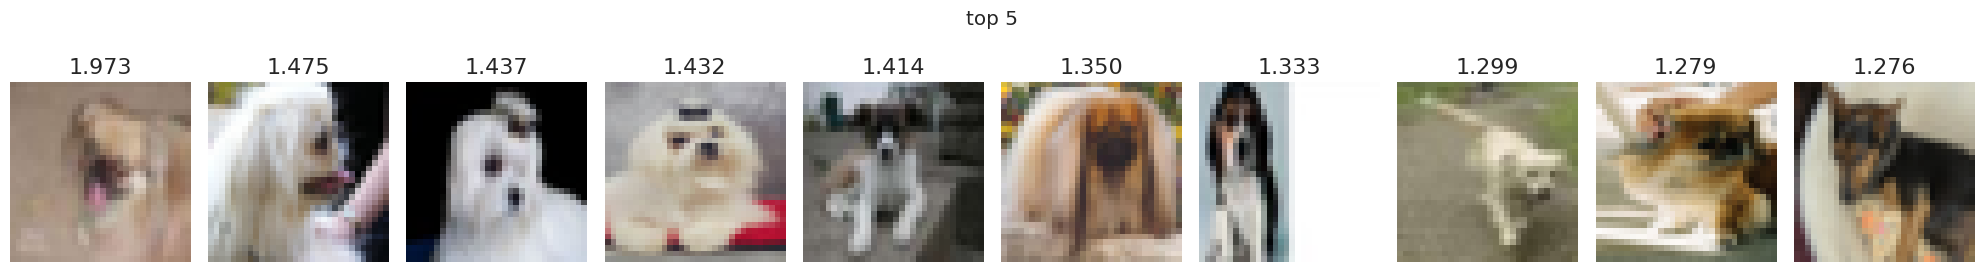



---


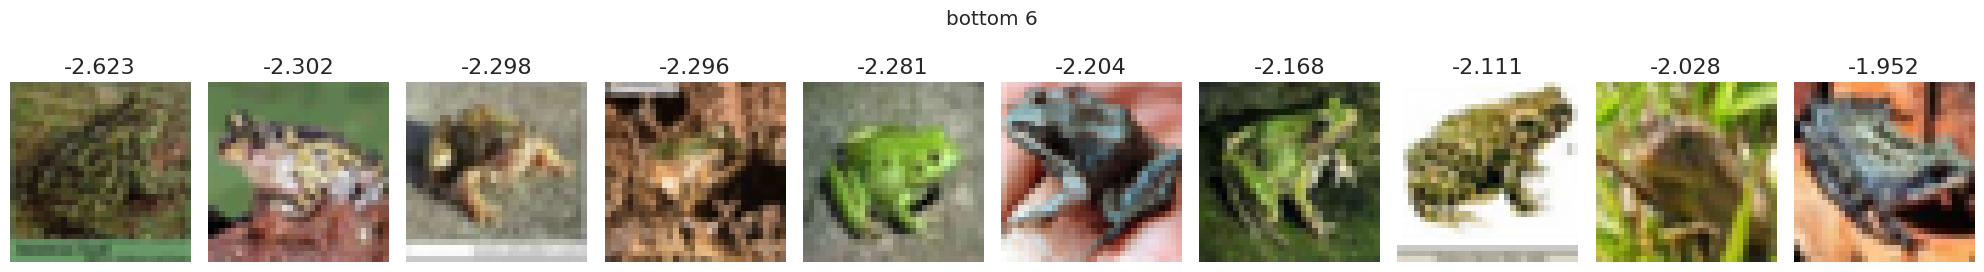

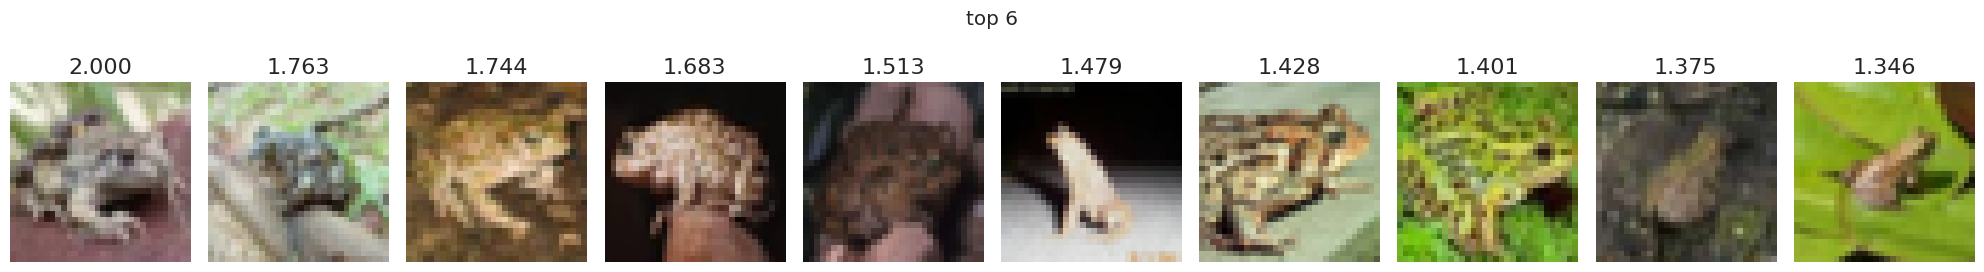



---


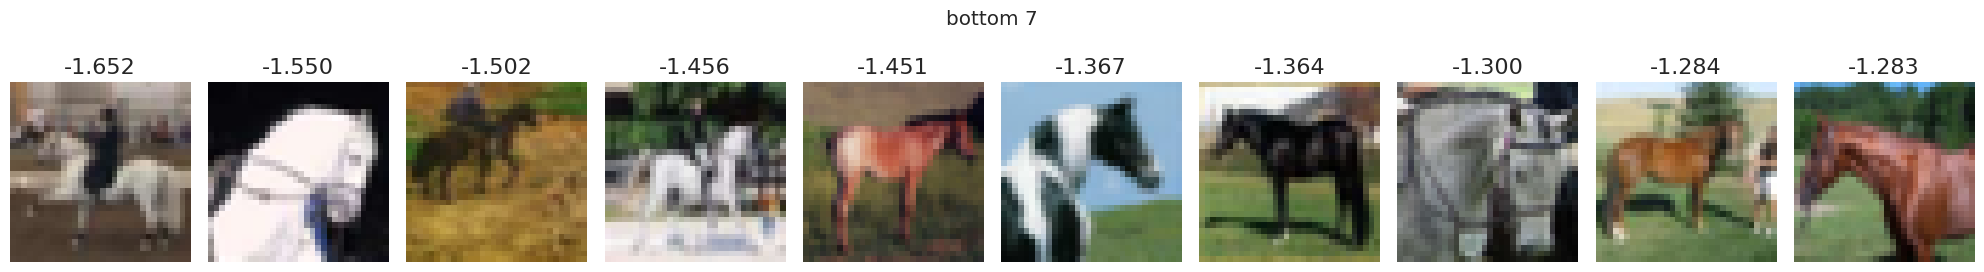

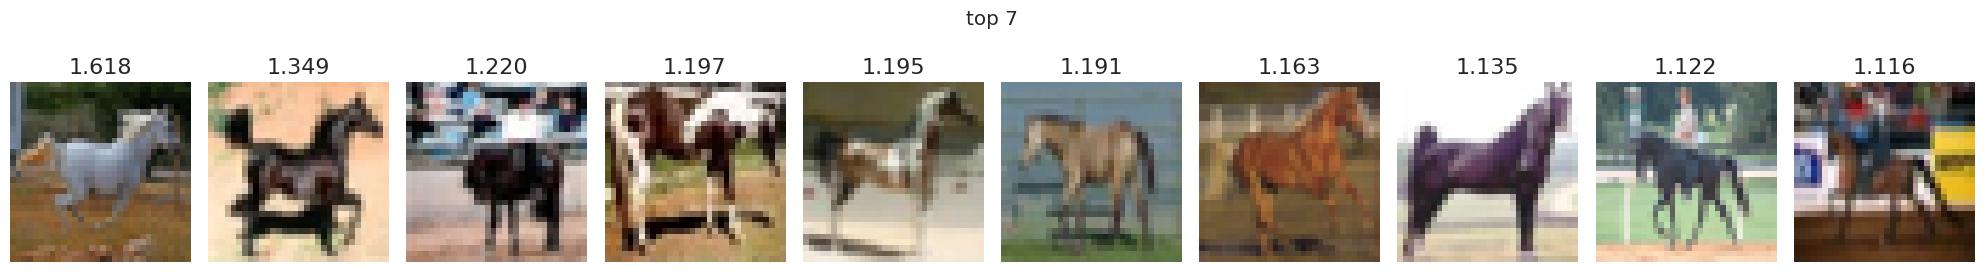



---


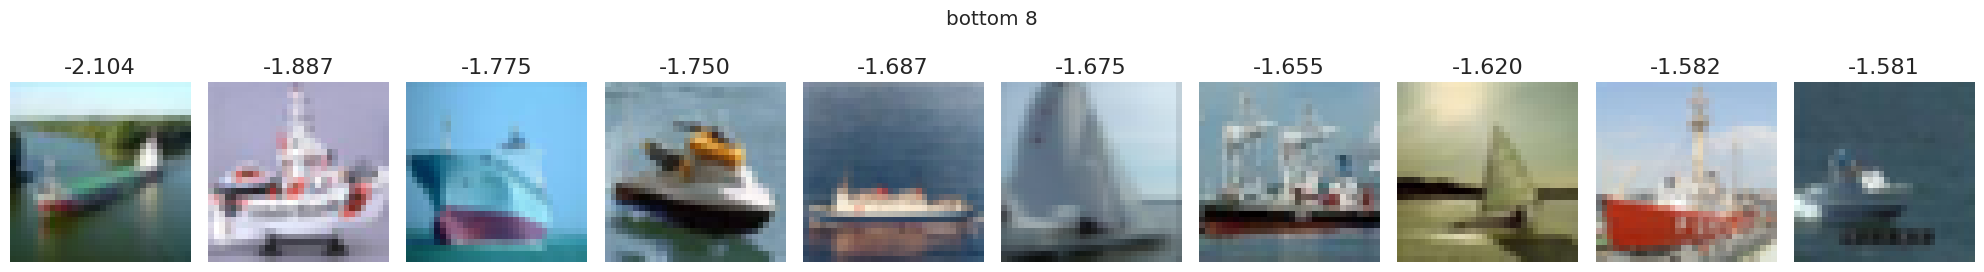

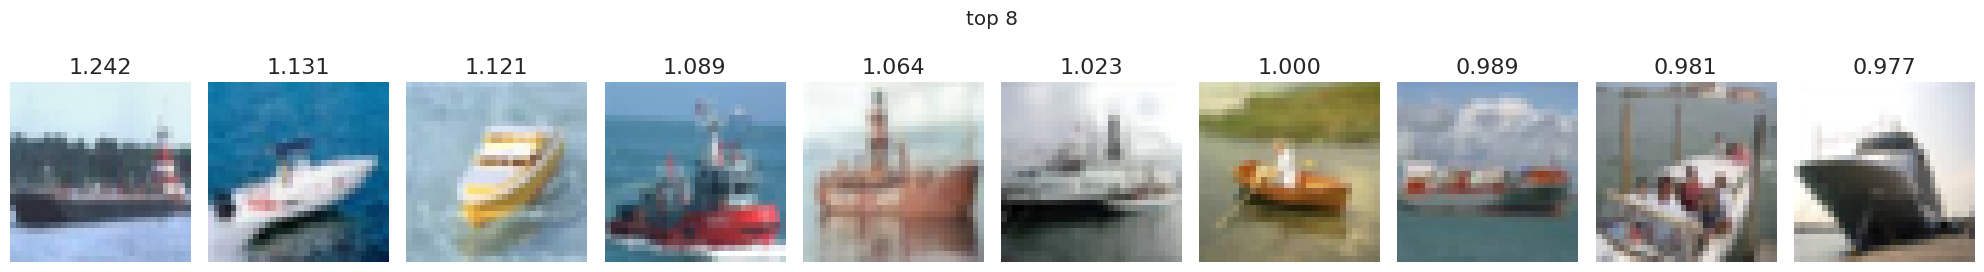



---


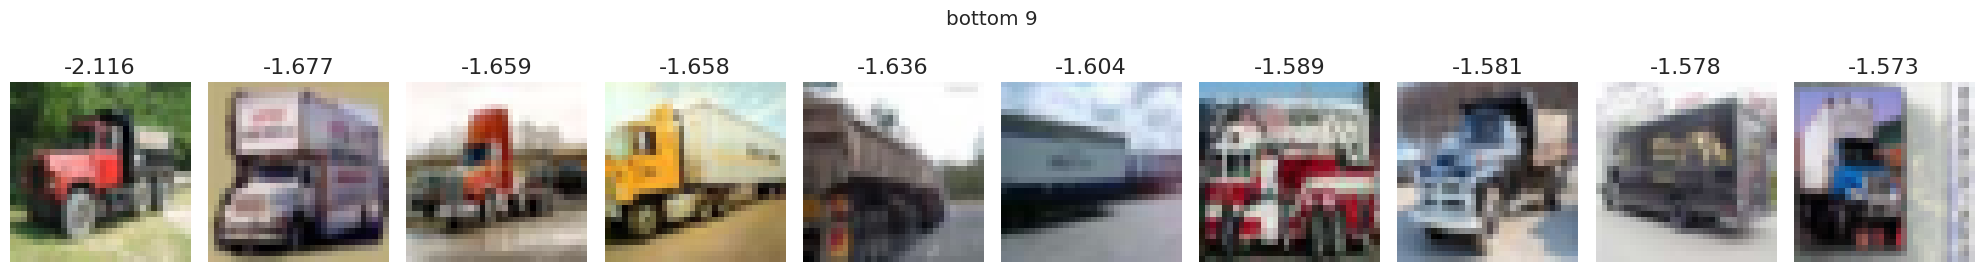

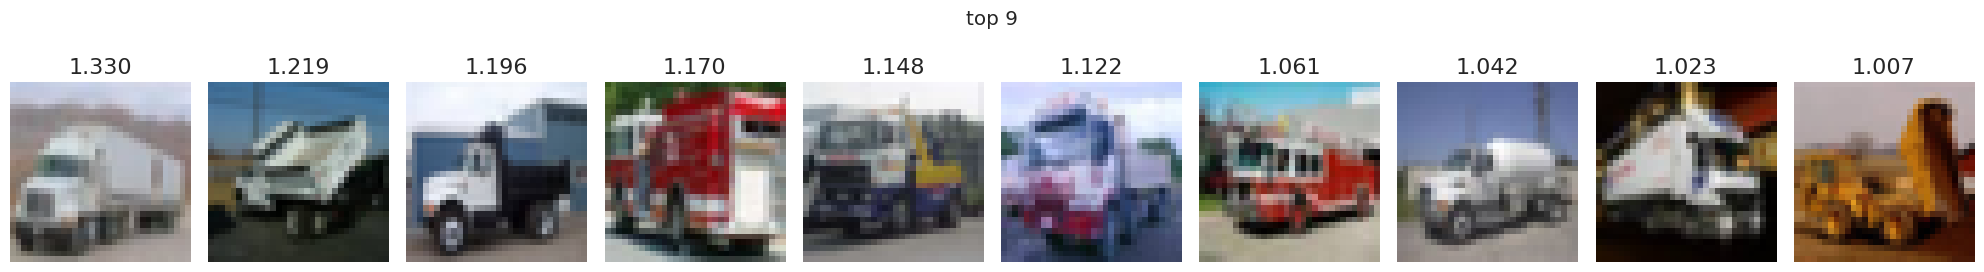

In [78]:
ds_root = "/mnt/cfs/datasets/cifar"
tds = torchvision.datasets.CIFAR10(ds_root, train=False)

def visualize_images(ds, ds_indices, ds_values, K=10, title=""):
    fig, ax = plt.subplots(1, K, figsize=(K*2, 3))
    for i in range(K):
        idx = ds_indices[i]
        ax[i].imshow(tds[idx][0])
        ax[i].axis(False)
        ax[i].set_title(f"{ds_values[i]:0.3f}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

gts = test_class
for c in range(10):
    print("---")
    mask = gts == c
    masked_indices = np.arange(len(mask))[mask]
    dv = big_clip_dv[mask]
    bottom_dv = np.argsort(dv)
    top_dv = bottom_dv[::-1]
    for order_name, order, cap in (
        ('bottom', bottom_dv, f"bottom {c}"),
        ("top", top_dv, f"top {c}"),
    ):
        vals = dv[order]
        visualize_images(tds, masked_indices[order], vals, title=cap)
        print("\n")
    

In [92]:
i = 0
d = svm_fitter.clfs[i].coef_.squeeze(0)
d = d/np.linalg.norm(d)
d = d.reshape(4, 28, 28)

In [79]:
cv_scores

[0.6343500380766687,
 0.5836128110240606,
 0.6007918297105161,
 0.5944643056626605,
 0.6226347537103605,
 0.6511176926873987,
 0.5482264742154372,
 0.6468443383717846,
 0.5976578704819584,
 0.596451625678191]

In [97]:
from ldm.models.diffusion.ddim import DDIMSampler

sampler = DDIMSampler(ldm_model)

In [184]:
torch.norm(start_code, dim=1).shape

torch.Size([1, 32, 32])

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 16.62it/s]


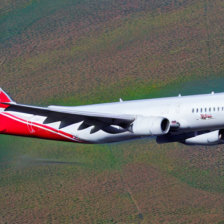

In [185]:
from torch import autocast
from einops import rearrange

precision_scope = autocast
batch_size = 1
upsample_scale = 8
opt = {
    'scale': 7.5,
    'C': 4,
    'H': 64*upsample_scale,
    'W': 64*upsample_scale,
    'f': 8,
    'n_samples': 1,
    'ddim_eta': 0,
    'ddim_steps': 50,
}
start_code = torch.randn([opt['n_samples'], opt['C'], opt['H'] // opt['f'], opt['W'] // opt['f']], device='cuda')
with torch.no_grad():
    with precision_scope("cuda"):
        with ldm_model.ema_scope():
            all_samples = list()
            uc = ldm_model.get_learned_conditioning(batch_size * [""])
            prompts = ["A photo of an airplane"]
            c = ldm_model.get_learned_conditioning(prompts)
            shape = [opt['C'], opt['H'] // opt['f'], opt['W'] // opt['f']]
            samples_ddim, _ = sampler.sample(S=opt['ddim_steps'],
                                             conditioning=c,
                                             batch_size=opt['n_samples'],
                                             shape=shape,
                                             verbose=False,
                                             unconditional_guidance_scale=opt['scale'],
                                             unconditional_conditioning=uc,
                                             eta=opt['ddim_eta'],
                                             x_T=start_code)
            #samples_ddim = torch.nn.Upsample(scale_factor=(2, 2), mode='bilinear')(samples_ddim)
#             samples_ddim = torch.nn.AvgPool2d((2, 2))(samples_ddim)
            x_samples_ddim = ldm_model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
            x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

            x_checked_image, has_nsfw_concept = check_safety(x_samples_ddim)

            x_checked_image_torch = torch.from_numpy(x_checked_image).permute(0, 3, 1, 2)

for x_sample in x_checked_image_torch:
    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
    img = PIL.Image.fromarray(x_sample.astype(np.uint8))
torchvision.transforms.Resize((224, 224))(img)

In [186]:
64*64

4096

In [5]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']

In [6]:
from failure_directions.src.config_parsing import ffcv_read_check_override_config
import yaml
%cd ../failure_directions
with open(processor.metrics['args']['config'], 'r') as file:
    fresh_hparams = yaml.safe_load(file)
fresh_hparams = ffcv_read_check_override_config(fresh_hparams)
%cd ../analysis_nbs


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs


In [7]:
svm_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): SequentialWithArgs(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

## Get SVM Directions

In [10]:
# Get big CLIP features
hparams = processor.hparams
clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'], arch='ViT-L/14')
clip_features = {}
for split, loader in processor.loaders.items():
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

100%|██████████| 300/300 [01:37<00:00,  3.06it/s]


In [11]:
svm_fitter = failure_directions.SVMFitter()
svm_fitter.set_preprocess()
val_gts, val_preds = processor.run_dict['val']['ys'], processor.run_dict['val']['preds']
cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'])

test_ys = processor.run_dict['test']['ys']
test_latents = clip_features['test']
big_clip_dv = svm_fitter.predict(ys=test_ys, latents=test_latents, compute_metrics=False)[1]

/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)


No whitening


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


In [10]:
import os
os.makedirs("cifar_large_directions")
for i in range(10):
    d = svm_fitter.clfs[i].coef_.squeeze(0)
    np.save(f"cifar_large_directions/dir{i}.npy", d/np.linalg.norm(d))

In [11]:
from failure_directions.src.clip_utils import get_caption_set
captions = failure_directions.get_caption_set('CIFAR')
ref_captions = clip_processor.evaluate_clip_captions(captions['reference'])
np.save("cifar_large_directions/ref_captions.npy", ref_captions.numpy())

excluding sennenhunde
excluding appenzeller
excluding smooth-haired fox terrier
excluding great pyrenees
excluding flat-coated retriever
excluding seizure-alert dog
excluding black-and-tan coonhound
excluding black-and-tan coonhound
excluding rhodesian ridgeback
excluding dandie dinmont
excluding rottweiler
excluding staffordshire bullterrier
excluding staffordshire bullterrier
excluding coonhound
excluding leonberg
excluding bluetick
excluding pekinese
excluding curly-coated retriever
excluding bullterrier
excluding clumber
excluding shetland sheepdog
excluding liver-spotted dalmatian
excluding lapdog
excluding shih-tzu
excluding weimaraner
excluding old english sheepdog
excluding blenheim spaniel
excluding coondog
excluding brabancon griffon
excluding bedlington terrier
excluding doberman
excluding bouvier des flandres
excluding bouvier des flandres
excluding bouvier des flandres
excluding entlebucher
excluding malamute
excluding norwich terrier
excluding housedog
excluding vizsla
ex

  0%|          | 0/11 [00:00<?, ?it/s]

dog
bird


100%|██████████| 11/11 [00:00<00:00, 159.66it/s]


automobile
airplane
truck
ship
frog
cat
horse
deer
reference


100%|██████████| 1/1 [00:00<00:00, 102.43it/s]


## Read the generated images

In [12]:
import src.stable_diffusion_utils as sd_utils
from src.stable_diffusion_utils import DiffDataset

In [13]:
images_path = "/mnt/cfs/home/saachij/src/stable-diffusion/slerp_images"

In [14]:
path_dict = sd_utils.get_path_dict(images_path, num_classes=10)
print(len(path_dict[0]['flip'][0]))

150


In [11]:
# def abs_walk(directory):
#     return [(p, os.path.join(directory, p)) for p in os.listdir(directory)]

# from collections import defaultdict
# num_classes = 10
# path_dict = {}
# for c in range(num_classes):
#     path_dict[c] = {
#         "flip": defaultdict(list),
#         "no_flip": defaultdict(list),
#     }

# for hash_name, hash_path in abs_walk(images_path):
#     for cls, cls_path in abs_walk(hash_path):
#         for flip_name, flip_path in abs_walk(cls_path):
#             sample_path = os.path.join(flip_path, "samples")
#             for image_name, image_path in abs_walk(sample_path):
#                 intensity = float(image_name.split("_")[1].split(".png")[0])
#                 path_dict[int(cls)][flip_name][intensity].append(image_path)

# class DiffDataset:
#     def __init__(self, path_dict, intensity, flip_name="flip", num_classes=10, transform=None, 
#                  num_imgs_per_class=None, cache_images=True, include_classes=None):
#         self.classes = []
#         self.img_paths = []
#         for c in range(num_classes):
#             if include_classes is not None and c not in include_classes:
#                 continue
#             arr = path_dict[c][flip_name][intensity]
#             if num_imgs_per_class is not None:
#                 arr = arr[:num_imgs_per_class]
#                 assert len(arr) == num_imgs_per_class
#             self.classes += [c]*len(arr)
#             self.img_paths += arr
#         if cache_images:
#             self.imgs = [pil_loader(img_path) for img_path in self.img_paths]
#         else:
#             self.imgs = None
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.classes)
    
#     def __getitem__(self, idx):
#         c = self.classes[idx]
#         img_path = self.img_paths[idx]
#         if self.imgs is not None:
#             img = self.imgs[idx]
#         else:
#             img = pil_loader(img_path)
#         if self.transform is not None:
#             img = self.transform(img)
#         return img, c
        

In [15]:
import torchvision.transforms as transforms
import torchvision
from failure_directions.src.decoders_and_transforms import PyTranslate, PyCutOut
hparams = processor.hparams

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    PyTranslate(2),
    PyCutOut(4, fill_color),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])
resize_base_transform = transforms.Compose([base_transform, transforms.Resize((32, 32))])
resize_train_transform = transforms.Compose([train_transform, transforms.Resize((32, 32))])

In [16]:
def evaluate_model(model, loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts)
    preds = torch.cat(preds)
    confs = torch.cat(confs)
    return gts, preds, confs

100%|██████████| 15/15 [00:00<00:00, 20.72it/s]


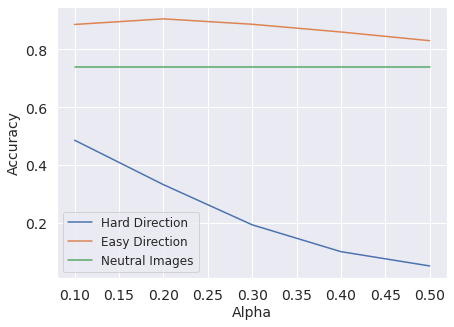

100%|██████████| 15/15 [00:00<00:00, 20.82it/s]


0 0.8933333158493042 0.47999998927116394 0.823


100%|██████████| 15/15 [00:00<00:00, 20.30it/s]


1 0.8933333158493042 0.6800000071525574 0.905


100%|██████████| 15/15 [00:00<00:00, 20.59it/s]


2 0.5600000023841858 0.14000000059604645 0.695


100%|██████████| 15/15 [00:00<00:00, 20.55it/s]


3 0.6866666674613953 0.013333333656191826 0.616


100%|██████████| 15/15 [00:00<00:00, 20.63it/s]


4 0.8266666531562805 0.6933333277702332 0.751


100%|██████████| 15/15 [00:00<00:00, 21.03it/s]


5 0.5666666626930237 0.006666666828095913 0.663


100%|██████████| 15/15 [00:00<00:00, 20.45it/s]


6 0.46000000834465027 0.0 0.851


100%|██████████| 15/15 [00:00<00:00, 20.72it/s]


7 0.9333333373069763 0.5533333420753479 0.834


100%|██████████| 15/15 [00:00<00:00, 20.43it/s]


8 0.8133333325386047 0.3799999952316284 0.903


100%|██████████| 15/15 [00:00<00:00, 20.76it/s]

9 0.7599999904632568 0.3866666555404663 0.864


In [18]:
# See relative accuracies
def get_diff_predictions(flip_name, intensity,target_class=None):
    base_ds = DiffDataset(path_dict, flip_name=flip_name, intensity=intensity, transform=resize_base_transform)
    base_loader = torch.utils.data.DataLoader(base_ds, batch_size=100, shuffle=False, drop_last=False)
    gts, preds, confs = evaluate_model(svm_model, base_loader)
    if target_class is not None:
        mask = gts == target_class
        gts, preds, confs = gts[mask], preds[mask], confs[mask]
    return gts, preds, confs, (gts==preds).float().mean().item()

intensities = [0.1, 0.2, 0.3, 0.4, 0.5]
base_acc = get_diff_predictions(flip_name="flip", intensity=0)[3]
flip_accs = [get_diff_predictions(flip_name="flip", intensity=u)[3] for u in intensities]
no_flip_accs = [get_diff_predictions(flip_name="no_flip", intensity=u)[3] for u in intensities]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.lineplot(x=intensities, y=flip_accs, label='Hard Direction', ax=ax)
sns.lineplot(x=intensities, y=no_flip_accs, label='Easy Direction', ax=ax)
sns.lineplot(x=intensities, y=[base_acc]*len(intensities), label='Neutral Images', ax=ax)
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
plt.show()

base_accs = []
orig_accs = []
flip_accs = []
for c in range(10):
    base_acc = get_diff_predictions(flip_name="flip", intensity=0, target_class=c)[3]
    orig_acc = (test_correct[test_class == c]).mean()
    flip_acc = get_diff_predictions(flip_name="flip", intensity=0.2, target_class=c)[3]
    print(c, base_acc, flip_acc, orig_acc)
    base_accs.append(base_acc)
    orig_accs.append(orig_acc)
    flip_accs.append(flip_acc)


In [28]:
print(*zip(np.arange(10), cifar_label_list))

(0, 'airplane') (1, 'automobile') (2, 'bird') (3, 'cat') (4, 'deer') (5, 'dog') (6, 'frog') (7, 'horse') (8, 'ship') (9, 'truck')


# Train models

In [29]:
bsz = fresh_hparams['batch_size']
ds_root = "/mnt/cfs/datasets/cifar"
orig_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=base_transform)
aug_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=train_transform)
test_ds = torchvision.datasets.CIFAR10(ds_root, train=False, transform=base_transform)

val_indices = processor.indices_dict['val_indices']
train_indices = processor.indices_dict['train_indices']

train_ds = torch.utils.data.Subset(aug_train_ds, train_indices)
val_ds = torch.utils.data.Subset(orig_train_ds, val_indices)
no_aug_train_ds = torch.utils.data.Subset(orig_train_ds, train_indices)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True, drop_last=True)
no_shuffle_train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bsz, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bsz, shuffle=False, drop_last=False)
no_aug_train_loader = torch.utils.data.DataLoader(no_aug_train_ds, batch_size=bsz, shuffle=False, drop_last=False)



In [30]:
import copy

def run_model(train_loader_, val_loader_, test_loader_, set_device=False):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = build_fn(hparams['arch'], hparams['num_classes'])
    model = model.cuda()

    training_args=hparams['training']
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

def run_finetune_model(train_loader_, val_loader_, test_loader_, set_device=False, freeze=True):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = copy.deepcopy(svm_model).train()
    
    if freeze:
        for name, p in model.named_parameters():
            if name.split('.')[0] != 'linear':
                print("freezing", name)
                p.requires_grad = False


    training_args=finetune_training
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

In [96]:
finetune_training = {
 'epochs': 15,
 'lr': 0.1,
 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005},
 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}
}

In [156]:
# See relative accuracies
#4
flip_interventions = {}
for intensity in [0, 0.1, 0.2]:
    flip_interventions[intensity] = []
    for v in range(1):
        base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=150,
                                         transform=resize_train_transform, include_classes=[3])
        synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
        synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
        flip_interventions[intensity].append(run_finetune_model(synth_train_loader, val_loader, test_loader, set_device=True, freeze=False))

flip_int_corrects = {}
for intensity in flip_interventions:
    arr = flip_interventions[intensity]
    flip_int_corrects[intensity] = [arr[v][0] ==  arr[v][1] for v in range(len(arr))]

Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.453, acc=0.879]


LR: 0.02, Train Loss: 0.2097, Train Acc: 0.9298, Val Loss: 0.6971, Val Acc: 0.7963


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.472, acc=0.864]


LR: 0.04, Train Loss: 0.1892, Train Acc: 0.9373, Val Loss: 0.7186, Val Acc: 0.7887


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.493, acc=0.868]


LR: 0.06, Train Loss: 0.1861, Train Acc: 0.9369, Val Loss: 0.7778, Val Acc: 0.7764


Val Epoch: 3:  35%|███▌      | 7/20 [00:00<00:01,  9.62it/s, loss=1.57, acc=0.518] 


KeyboardInterrupt: 

In [173]:
flip_interventions = torch.load("/mnt/cfs/home/saachij/src/failure-directions/failure_directions/sd_files/cifar10/cifar10_sd_results.pt")

In [175]:
flip_interventions.keys()

dict_keys([0, 0.1, 0.2, 0.3])

In [166]:
flip_int_corrects = {}
for intensity in flip_interventions:
    arr = flip_interventions[intensity]
    flip_int_corrects[intensity] = [arr[v][0] ==  arr[v][1] for v in range(len(arr))]

tensor(0.8023) tensor(0.8042)
tensor(0.7954) tensor(0.8042)
tensor(0.8014) tensor(0.8042)


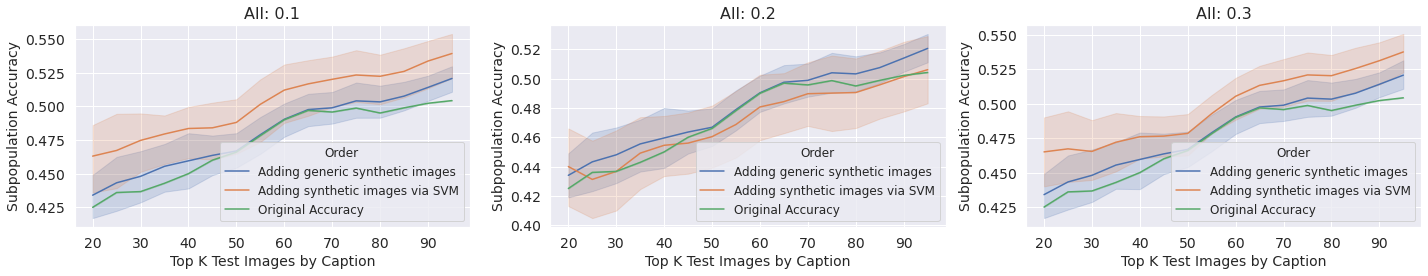

In [182]:
def get_dv_indices(target_c):
    dv = big_clip_dv
    mask = test_class == target_c
    inds = np.arange(len(dv))[mask]
    return inds[np.argsort(dv[mask])]

fig, ax_ = plt.subplots(1, 3, figsize=(20, 4))
cls = -1
trials = 5
for intensity_idx, intensity in enumerate([0.1, 0.2, 0.3]):
    ax = ax_[intensity_idx]
    load_corrects = {
        'flip': flip_int_corrects[intensity],
        'base': flip_int_corrects[0],
        'baseline': [torch.tensor(test_correct == 1) for _ in range(trials)],

    }
    print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

    K = 100


    all_dfs = []
    # valid_classes = np.arange(10)
    if cls == -1:
        valid_classes = np.arange(10)
    else:
        valid_classes = [cls]
    for v in range(trials):
        xaxis = np.arange(20, 100, 5)
        accs = {k:[] for k in load_corrects.keys()}
        for K in xaxis:
            minority_indices = np.concatenate([get_dv_indices(target_c)[:K] for target_c in valid_classes])
#             minority_indices = np.concatenate([saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')][0][:K] for target_c in valid_classes])
            for k in load_corrects.keys():
                accs[k].append(load_corrects[k][v][minority_indices].float().mean().item())
        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = accs['base']
        df['Adding synthetic images via SVM'] = accs['flip']
        df['Original Accuracy'] = accs['baseline']
        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        all_dfs.append(df)


    all_df = pd.concat(all_dfs).reset_index()

    sns.lineplot(data=all_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    t = 'All' if cls == -1 else cifar_label_list[cls]  
    ax.set_title(f'{t}: {intensity}')
plt.tight_layout()
plt.show()


In [160]:
(test_class == 3).sum()

1000

In [51]:
tds = torchvision.datasets.CIFAR10(ds_root, train=False)


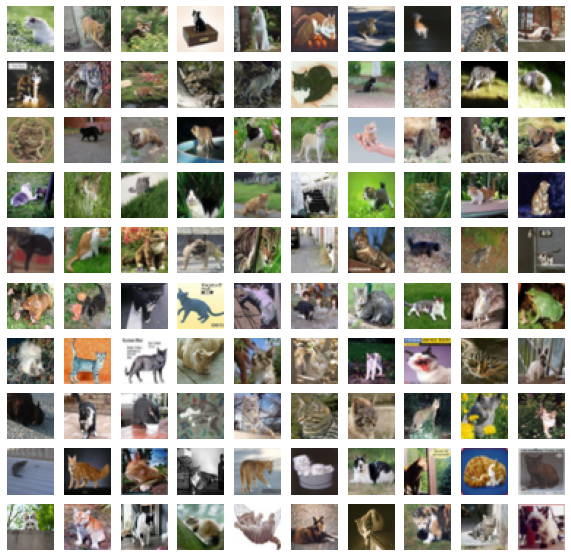

In [52]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
ax_ = ax.flatten()
for i in range(len(ax_)):
    ax_[i].imshow(tds[minority_indices[i]][0])
    ax_[i].grid(False)
    ax_[i].axis(False)
plt.show()

In [11]:
# See relative accuracies
flip_interventions = {}
for intensity in [0, 0.1, 0.2, 0.3]:
    base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=100,
                                     transform=resize_train_transform)
    synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
    synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
    flip_interventions[intensity] = [
        run_finetune_model(synth_train_loader, val_loader, test_loader, set_device=True)
        for _ in range (1)
    ]

In [54]:
# See relative accuracies
flip_interventions = {}
for intensity in [0, 0.1, 0.2, 0.3]:
    base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=100,
                                     transform=resize_train_transform)
    synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
    synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
    flip_interventions[intensity] = [
        run_model(synth_train_loader, val_loader, test_loader, set_device=True)
        for _ in range (1)
    ]

KeyboardInterrupt: 

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


100%|██████████| 300/300 [00:05<00:00, 57.17it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(source

consistent with old results 1.0
excluding soft-coated wheaten terrier
excluding bullterrier
excluding bouvier des flandres
excluding bouvier des flandres
excluding bouvier des flandres
excluding wire-haired fox terrier
excluding shetland sheepdog
excluding ibizan hound
excluding doberman
excluding brabancon griffon
excluding lapdog
excluding entlebucher
excluding blenheim spaniel
excluding black-and-tan coonhound
excluding black-and-tan coonhound
excluding american staffordshire terrier
excluding plott hound
excluding housedog
excluding bedlington terrier
excluding dandie dinmont
excluding vizsla
excluding belgian sheepdog
excluding rottweiler
excluding sennenhunde
excluding liver-spotted dalmatian
excluding staffordshire bullterrier
excluding staffordshire bullterrier
excluding leonberg
excluding pekinese
excluding curly-coated retriever
excluding german short-haired pointer
excluding shih-tzu
excluding rhodesian ridgeback
excluding seizure-alert dog
excluding old english sheepdog
exc

100%|██████████| 11/11 [00:00<00:00, 170.76it/s]

dog
bird
automobile
airplane
truck
ship
frog
cat
horse
deer
reference
0.6642218046323067
performing classify captions on svm



100%|██████████| 1/1 [00:00<00:00, 102.67it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

{'neg_captions': array(['a photo of a red bomber', 'a photo of a red bomber inside',
       'a photo of a red reconnaissance plane inside',
       'a photo of a red bomber in the air',
       'a photo of a red reconnaissance plane',
       'a photo of a red bomber flying',
       'a photo of a red bomber outside',
       'a photo of a red reconnaissance plane outside',
       'a photo of a red dive bomber inside',
       'a photo of a red dive bomber'], dtype='<U62'),
 'neg_latents': array([[ 0.4033203 ,  0.3310547 ,  0.12005615, ..., -0.29614258,
        -0.16247559, -0.15063477],
       [ 0.17163086,  0.28735352, -0.00491714, ..., -0.13024902,
        -0.01203918, -0.10223389],
       [ 0.08856201,  0.19128418,  0.06988525, ...,  0.17053223,
         0.11920166, -0.14929199],
       ...,
       [ 0.18725586,  0.22180176,  0.19677734, ...,  0.11138916,
         0.05429077, -0.15112305],
       [ 0.22802734, -0.00438309, -0.09326172, ...,  0.24707031,
         0.25146484,  0.05679321],

100%|██████████| 1/1 [00:00<00:00, 108.37it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a ambulance', 'a photo of a ambulance outside',
       'a photo of a ambulance inside', 'a photo of a ambulance parked',
       'a photo of a brown ambulance inside',
       'a photo of a brown ambulance outside',
       'a photo of a brown ambulance',
       'a photo of a white ambulance inside',
       'a photo of a white ambulance outside', 'a photo of a stock car'],
      dtype='<U60'),
 'neg_latents': array([[ 0.12438965,  0.26489258,  0.05358887, ..., -0.42651367,
        -0.22302246, -0.23632812],
       [ 0.04193115,  0.35375977,  0.12487793, ..., -0.42138672,
        -0.19482422, -0.1809082 ],
       [ 0.02941895,  0.22436523, -0.01295471, ..., -0.36132812,
        -0.04232788, -0.23461914],
       ...,
       [-0.04595947,  0.05499268,  0.15649414, ..., -0.2631836 ,
        -0.17602539, -0.4020996 ],
       [-0.03607178,  0.14196777,  0.24609375, ..., -0.27441406,
        -0.25610352, -0.37060547],
       [-0.00428391,  0.12756348, -0.25073

100%|██████████| 1/1 [00:00<00:00, 131.35it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white oscine inside',
       'a photo of a white twitterer inside',
       'a photo of a white twitterer flying',
       'a photo of a honey guide inside',
       'a photo of a orange twitterer inside',
       'a photo of a white honey guide inside',
       'a photo of a twitterer flying',
       'a photo of a white oscine in the air',
       'a photo of a red twitterer inside', 'a photo of a cackler inside'],
      dtype='<U65'),
 'neg_latents': array([[-0.19812012,  0.35253906, -0.18237305, ..., -0.22497559,
        -0.00176239, -0.14990234],
       [-0.19262695, -0.24230957, -0.13208008, ..., -0.28979492,
        -0.1194458 ,  0.04562378],
       [ 0.20727539,  0.26586914, -0.18103027, ..., -0.27563477,
         0.1315918 , -0.5126953 ],
       ...,
       [ 0.0612793 ,  0.29370117, -0.21142578, ..., -0.28149414,
         0.0871582 , -0.5449219 ],
       [-0.1829834 , -0.08105469, -0.21484375, ..., -0.34960938,
        -0.05825806,  0.2932129 ],

100%|██████████| 1/1 [00:00<00:00, 122.01it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white mouser on the grass',
       'a photo of a blue mouser on the grass',
       'a photo of a white ocelot on the grass',
       'a photo of a green mouser on the grass',
       'a photo of a blue ocelot on the grass',
       'a photo of a red mouser on the grass',
       'a photo of a white cougar on the grass',
       'a photo of a green cougar on the grass',
       'a photo of a blue cougar on the grass',
       'a photo of a white persian cat on the grass'], dtype='<U60'),
 'neg_latents': array([[-0.22460938, -0.33374023,  0.10137939, ..., -0.07196045,
        -0.24133301, -0.09991455],
       [-0.10229492, -0.3071289 ,  0.01446533, ..., -0.12573242,
        -0.2783203 ,  0.24780273],
       [-0.16906738, -0.4230957 , -0.13537598, ...,  0.3215332 ,
        -0.22241211,  0.01625061],
       ...,
       [ 0.05981445, -0.1048584 , -0.03503418, ..., -0.09448242,
        -0.08703613,  0.28955078],
       [ 0.02685547, -0.24157715, -0.04205322, ..

100%|██████████| 1/1 [00:00<00:00, 105.27it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a kob inside', 'a photo of a kob',
       'a photo of a sassaby', 'a photo of a white kob in the snow',
       'a photo of a kob in the snow', 'a photo of a white kob inside',
       'a photo of a sassaby inside',
       'a photo of a white sassaby in the snow',
       'a photo of a sassaby outside', 'a photo of a sassaby in the snow'],
      dtype='<U63'),
 'neg_latents': array([[-0.21325684,  0.21948242, -0.04556274, ..., -0.5048828 ,
        -0.13024902,  0.2397461 ],
       [-0.1430664 ,  0.2956543 ,  0.08148193, ..., -0.63916016,
        -0.24694824,  0.22277832],
       [-0.24768066,  0.00634003, -0.10797119, ..., -0.828125  ,
        -0.08276367, -0.27929688],
       ...,
       [-0.1796875 , -0.01174164,  0.03137207, ..., -0.6254883 ,
        -0.01927185, -0.93359375],
       [-0.24414062,  0.0927124 , -0.07055664, ..., -0.88378906,
        -0.09381104, -0.26635742],
       [-0.25317383,  0.02832031, -0.07012939, ..., -0.8955078 ,
         0.

100%|██████████| 1/1 [00:00<00:00, 131.66it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a black feist', 'a photo of a black feist outside',
       'a photo of a feist', 'a photo of a black mexican hairless inside',
       'a photo of a brown feist', 'a photo of a black mexican hairless',
       'a photo of a brown mexican hairless inside',
       'a photo of a black mexican hairless outside',
       'a photo of a black feist inside', 'a photo of a green feist'],
      dtype='<U69'),
 'neg_latents': array([[ 0.12200928, -0.13061523, -0.18481445, ..., -0.18774414,
        -0.08782959,  0.34375   ],
       [ 0.17529297, -0.03115845, -0.17346191, ..., -0.11071777,
        -0.02468872,  0.29541016],
       [-0.04125977, -0.03536987, -0.18225098, ..., -0.43969727,
        -0.17810059,  0.35595703],
       ...,
       [ 0.01129913, -0.0259552 , -0.17626953, ...,  0.24804688,
         0.11456299, -0.08331299],
       [ 0.12646484, -0.21240234, -0.2705078 , ..., -0.22265625,
        -0.0814209 ,  0.45043945],
       [ 0.01450348, -0.12561035, -0

100%|██████████| 1/1 [00:00<00:00, 106.02it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a agua', 'a photo of a agua inside',
       'a photo of a agua outside', 'a photo of a black agua inside',
       'a photo of a black agua', 'a photo of a black agua outside',
       'a photo of a brown agua', 'a photo of a brown agua inside',
       'a photo of a white agua inside',
       'a photo of a brown agua outside'], dtype='<U68'),
 'neg_latents': array([[-0.15551758,  0.38793945,  0.18383789, ..., -0.27148438,
         0.03216553,  0.05941772],
       [-0.22351074,  0.43310547,  0.1282959 , ..., -0.27783203,
         0.12469482, -0.04089355],
       [-0.17822266,  0.54785156,  0.14880371, ..., -0.26904297,
         0.12731934,  0.09912109],
       ...,
       [-0.05691528,  0.5541992 ,  0.08105469, ..., -0.26635742,
         0.05380249, -0.1352539 ],
       [-0.3310547 ,  0.39892578,  0.234375  , ..., -0.25219727,
         0.1451416 , -0.24023438],
       [ 0.01754761,  0.54296875,  0.04727173, ..., -0.20349121,
        -0.02075195, -0.1446

100%|██████████| 1/1 [00:00<00:00, 133.34it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a protohippus inside',
       'a photo of a blue eohippus inside', 'a photo of a blue eohippus',
       'a photo of a wild horse', 'a photo of a white eohippus inside',
       'a photo of a blue steed inside', 'a photo of a eohippus inside',
       'a photo of a blue tarpan inside',
       'a photo of a green eohippus inside', 'a photo of a protohippus'],
      dtype='<U63'),
 'neg_latents': array([[-0.19116211,  0.33618164, -0.37451172, ..., -0.17797852,
        -0.23901367, -0.25439453],
       [-0.3017578 ,  0.00455856, -0.09680176, ..., -0.07965088,
        -0.12585449,  0.171875  ],
       [-0.20568848,  0.07617188,  0.11871338, ...,  0.05502319,
        -0.10473633,  0.10803223],
       ...,
       [-0.19360352,  0.21838379,  0.0096817 , ..., -0.04486084,
        -0.46240234,  0.0647583 ],
       [-0.3527832 ,  0.09997559, -0.28759766, ..., -0.0567627 ,
         0.0411377 ,  0.2241211 ],
       [ 0.01934814,  0.4567871 , -0.28881836, ..., -0.15

100%|██████████| 1/1 [00:00<00:00, 114.89it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a racing gig', 'a photo of a blue racing gig outside',
       'a photo of a racing gig outside', 'a photo of a blue racing gig',
       'a photo of a racing gig inside',
       'a photo of a blue racing gig inside',
       'a photo of a blue sloop of war outside',
       'a photo of a white racing gig outside',
       'a photo of a blue racing gig on the horizon',
       'a photo of a blue sloop of war'], dtype='<U75'),
 'neg_latents': array([[ 0.2331543 ,  0.05691528,  0.03704834, ...,  0.11865234,
         0.07855225, -0.18457031],
       [ 0.1973877 ,  0.05496216,  0.03317261, ..., -0.02108765,
         0.10809326,  0.00676346],
       [ 0.19897461,  0.0034771 ,  0.03433228, ..., -0.0254364 ,
         0.21875   , -0.0423584 ],
       ...,
       [ 0.03034973,  0.02455139,  0.15991211, ..., -0.11199951,
         0.15441895, -0.2890625 ],
       [ 0.20385742, -0.01551056,  0.06518555, ...,  0.24902344,
         0.07141113,  0.07067871],
       [-0.1

100%|██████████| 1/1 [00:00<00:00, 108.62it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white passenger van',
       'a photo of a white passenger van inside',
       'a photo of a white passenger van on the road',
       'a photo of a white passenger van outside',
       'a photo of a blue passenger van on the road',
       'a photo of a blue passenger van',
       'a photo of a brown passenger van on the road',
       'a photo of a blue passenger van inside',
       'a photo of a blue passenger van outside',
       'a photo of a orange passenger van on the road'], dtype='<U56'),
 'neg_latents': array([[ 0.0612793 ,  0.1538086 ,  0.15783691, ...,  0.25756836,
        -0.05764771, -0.17041016],
       [-0.0194397 ,  0.2244873 ,  0.05880737, ...,  0.19238281,
        -0.02528381, -0.18786621],
       [-0.0557251 ,  0.1685791 ,  0.14208984, ...,  0.25732422,
         0.01333618, -0.16625977],
       ...,
       [ 0.18969727,  0.10583496, -0.03022766, ...,  0.28515625,
        -0.11218262,  0.2331543 ],
       [ 0.26245117,  0.11224365, 

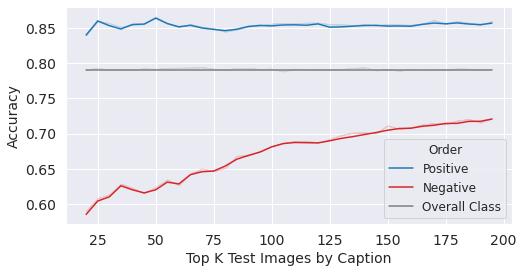

In [53]:
import src.clip_utils as clip_utils
cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])

clip_analyzer = viz_utils.ClipAnalyzer(
    processor=processor, svm_model_name=svm_model_name, caption_set_name="CIFAR", class_names=cifar_label_list)

def get_cdf(arr, K_range=None):
    out = []
    if K_range is None:
        K_range = np.arange(10, len(arr), 10)
    for K in K_range:
        out.append(arr[:K].mean())
    out = np.array(out)
    return out, K_range

saved_caption_and_most_relevant_imgs = {}
all_dfs = []
for target_class in range(10):
    print(processor.metrics['cv_scores'][target_class])
    print("performing classify captions on svm")
    result = clip_analyzer.get_svm_style_top_K(target_class, 'all')
    print("--------")

    cdfs = {}
    class_mask = test_class==target_class
    masked_indices = np.arange(len(test_class))[class_mask]
    # K_range = np.arange(10, len(masked_indices), 10)
    K_range=np.arange(20, 200, 5)
    for caption_index in range(1):
        for direction in ['pos', 'neg']:
            caption_text = result[f'{direction}_captions'][caption_index]
            print(f"{direction}: {caption_text}")
            top_caption_latent = torch.tensor(result[f'{direction}_latents'][caption_index]).cuda()

            image_latents = clip_analyzer.clip_features['test'][class_mask].cuda()
            image_angles = clip_utils.order_descriptions_angle(mean_point=top_caption_latent.unsqueeze(0), query_points=image_latents)
            image_order = np.argsort(image_angles)[::-1]
            saved_caption_and_most_relevant_imgs[(target_class, caption_index, direction)] = (masked_indices[image_order], caption_text)
            dir_name = 'Positive' if direction == 'pos' else 'Negative' 
            cdfs[dir_name], _ = get_cdf(test_correct[masked_indices[image_order]], K_range)
            # uncomment this to display the images

        df = pd.DataFrame()
        df['Top K'] = K_range
        for d, v in cdfs.items():
            df[d] = v
        df['Overall Class'] = test_correct[masked_indices].mean()
        df = df.melt('Top K', var_name='Order', value_name='Accuracy')
        all_dfs.append(df)
    
combined_df = pd.concat(all_dfs).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.lineplot(data=combined_df, x='Top K', y='Accuracy', hue='Order', ax=ax, 
             hue_order=['Positive', 'Negative', 'Overall Class'], 
            palette=[BLUE, RED, GRAY], ci=False)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=labels)
ax.set_xlabel("Top K Test Images by Caption")
plt.show()
    

tensor(0.8023) tensor(0.8042)


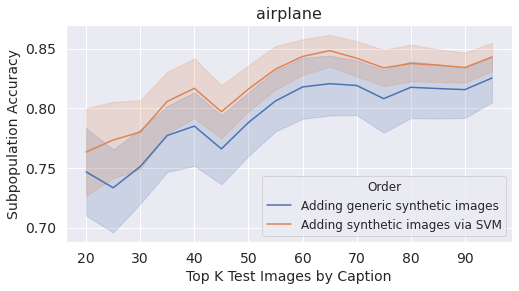

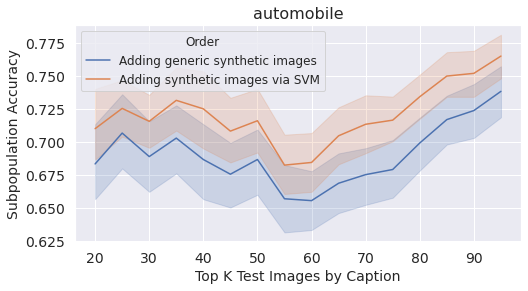

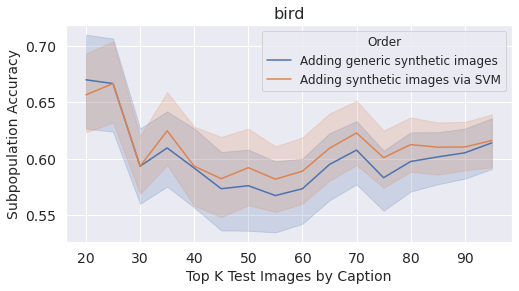

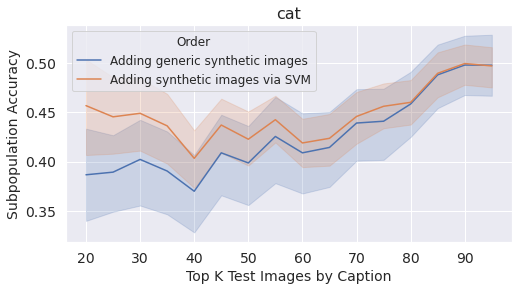

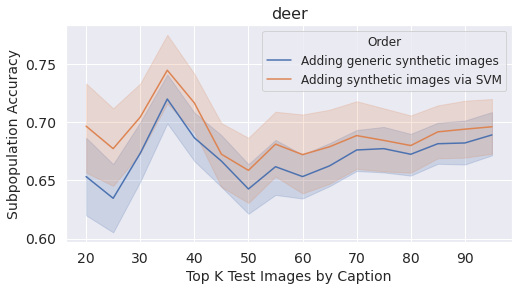

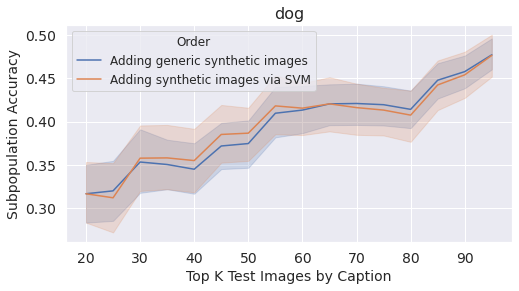

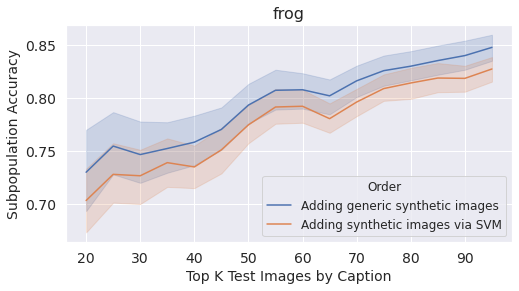

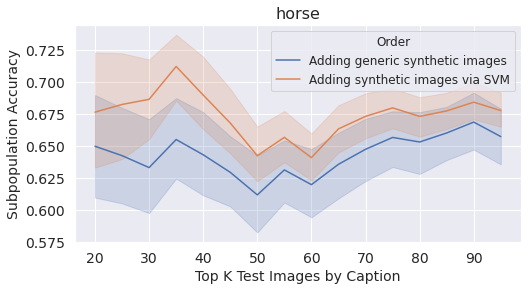

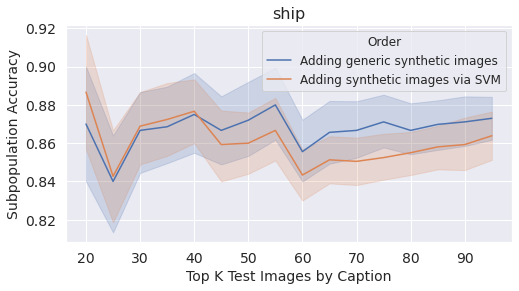

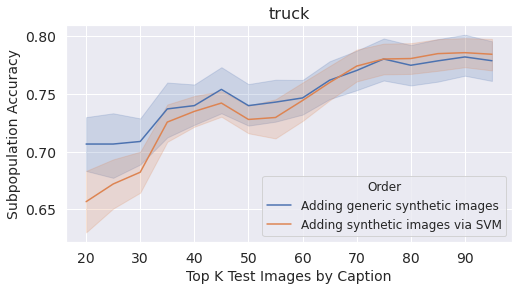

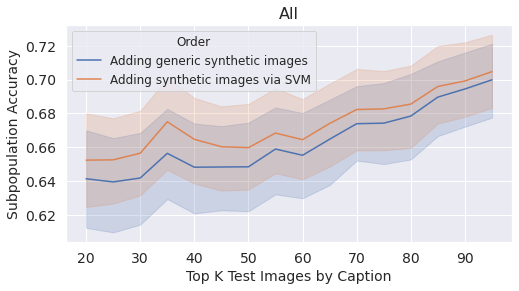

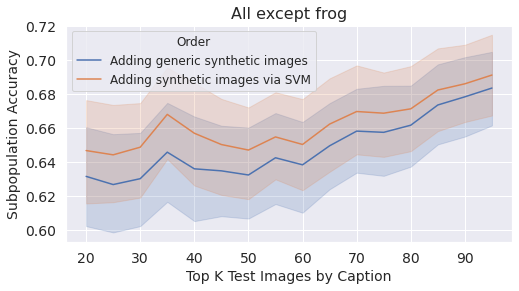

In [54]:
intensity = 0.1
load_corrects = {
    'flip': [(flip_interventions[intensity][u][0] == flip_interventions[intensity][u][1]) for u in range(len(flip_interventions[intensity]))],
    'base': [(flip_interventions[0][u][0] == flip_interventions[0][u][1]) for u in range(len(flip_interventions[0]))],
#     'none': [(no_intervention[u][0] == no_intervention[u][1]) for u in range(5)],

}
trials = len(flip_interventions[0])
print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

K = 100



#         print(cifar_label_list[target_class], base_accs[target_class], orig_accs[target_class])
all_dfs = []
for v in range(trials):
    dfs = []
    for target_c in np.arange(num_classes):
        xaxis = np.arange(20, 100, 5)
        indices, caption = saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')]
        base, _ = get_cdf(load_corrects['base'][v][indices].float(), xaxis)
        flip, _ = get_cdf(load_corrects[('flip')][v][indices].float(), xaxis)

        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = base
        df['Adding synthetic images via SVM'] = flip

        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        df['Class'] = target_c
        dfs.append(df)
    combined_df = pd.concat(dfs).reset_index()
    combined_df = combined_df.groupby(['Top K', 'Order', 'Class']).mean().reset_index()[['Top K', 'Order', 'Subpopulation Accuracy', 'Class']]
    all_dfs.append(combined_df)
    
def plot_sub_df(sub_df, title):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.lineplot(data=sub_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    ax.set_title(title)
    plt.show()
    
df = pd.concat(all_dfs).reset_index()
for target_class in np.arange(num_classes):
    plot_sub_df(df[df['Class'] == target_class], cifar_label_list[target_class])
plot_sub_df(df, "All")
plot_sub_df(df[df['Class'] != 6], "All except frog")
    

tensor(0.8023) tensor(0.8042)
tensor(0.7954) tensor(0.8042)
tensor(0.8014) tensor(0.8042)


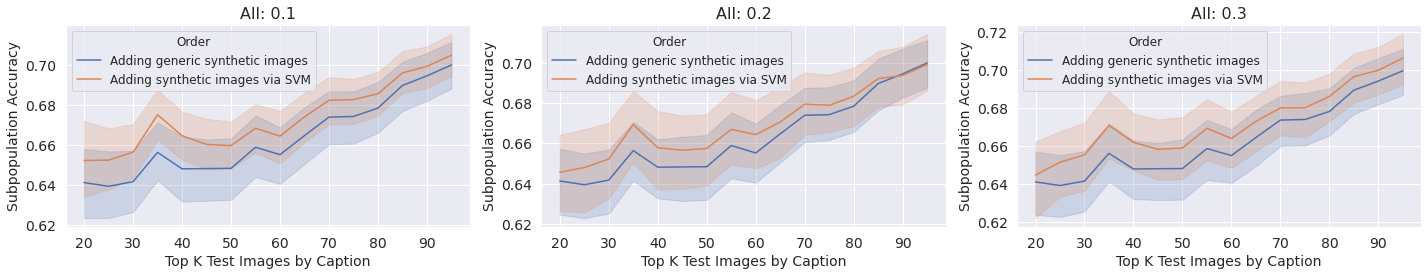

In [73]:
def get_dv_indices(target_c):
    mask = test_class == target_c
    inds = np.arange(len(big_clip_dv))[mask]
    return inds[np.argsort(big_clip_dv[mask])]

fig, ax_ = plt.subplots(1, 3, figsize=(20, 4))
cls = -1
if cls == -1:
    flip_interventions = torch.load("cifar10_sd_results.pt")
else:
    flip_interventions = torch.load(f"/mnt/cfs/home/saachij/src/failure-directions/failure_directions/cifar_sd_{cls}.pt")
for intensity_idx, intensity in enumerate([0.1, 0.2, 0.3]):
    ax = ax_[intensity_idx]
    load_corrects = {
        'flip': [(flip_interventions[intensity][u][0] == flip_interventions[intensity][u][1]) for u in range(len(flip_interventions[intensity]))],
        'base': [(flip_interventions[0][u][0] == flip_interventions[0][u][1]) for u in range(len(flip_interventions[0]))],
    #     'none': [(no_intervention[u][0] == no_intervention[u][1]) for u in range(5)],

    }
    trials = len(flip_interventions[0])
    print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

    K = 100


    all_dfs = []
    # valid_classes = np.arange(10)
    if cls == -1:
        valid_classes = np.arange(10)
    else:
        valid_classes = [cls]
    for v in range(trials):
        xaxis = np.arange(20, 100, 5)
        base, flip = [], []
        for K in xaxis:
#             minority_indices = np.concatenate([get_dv_indices(target_c)[:K] for target_c in valid_classes])
            minority_indices = np.concatenate([saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')][0][:K] for target_c in valid_classes])
            base.append(load_corrects['base'][v][minority_indices].float().mean().item())
            flip.append(load_corrects[('flip')][v][minority_indices].float().float().mean().item())
        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = base
        df['Adding synthetic images via SVM'] = flip
        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        all_dfs.append(df)


    all_df = pd.concat(all_dfs).reset_index()

    sns.lineplot(data=all_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    t = 'All' if cls == -1 else cifar_label_list[cls]  
    ax.set_title(f'{t}: {intensity}')
plt.tight_layout()
plt.show()


In [62]:
sub_df

,index,Top K,Order,Subpopulation Accuracy,Class
9,9,20,Adding generic synthetic images,0.700000,9
19,19,20,Adding synthetic images via SVM,0.750000,9
29,29,25,Adding generic synthetic images,0.720000,9
39,39,25,Adding synthetic images via SVM,0.760000,9
49,49,30,Adding generic synthetic images,0.733333,9
...,...,...,...,...,...
4759,279,85,Adding synthetic images via SVM,0.823529,9
4769,289,90,Adding generic synthetic images,0.833333,9
4779,299,90,Adding synthetic images via SVM,0.822222,9
4789,309,95,Adding generic synthetic images,0.831579,9


In [52]:
df

,index,Top K,Order,Subpopulation Accuracy,Class
0,0,20,Adding generic synthetic images,0.800000,0
1,1,20,Adding generic synthetic images,0.700000,1
2,2,20,Adding generic synthetic images,0.650000,2
3,3,20,Adding generic synthetic images,0.350000,3
4,4,20,Adding generic synthetic images,0.650000,4
...,...,...,...,...,...
4795,315,95,Adding synthetic images via SVM,0.589474,5
4796,316,95,Adding synthetic images via SVM,0.852632,6
4797,317,95,Adding synthetic images via SVM,0.694737,7
4798,318,95,Adding synthetic images via SVM,0.915789,8


In [65]:
clip_analyzer.captions['reference']

['a photo of a airplane',
 'a photo of a automobile',
 'a photo of a bird',
 'a photo of a cat',
 'a photo of a deer',
 'a photo of a dog',
 'a photo of a frog',
 'a photo of a horse',
 'a photo of a ship',
 'a photo of a truck']

In [13]:
out = torch.load("synth_model_results.pt")

In [14]:
no_intervention = out['no_intervention']
flip_interventions = out['flip_intervention']
base_intervention = out['base_intervention']

In [81]:
no_intervention

[(tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.9736, 0.9980, 0.9996,  ..., 0.9998, 0.9998, 0.9724])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.8502, 0.9268, 0.9994,  ..., 0.9996, 0.9960, 0.9489])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.7708, 0.9999, 1.0000,  ..., 0.9988, 0.9972, 0.9987])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.6072, 0.9871, 0.9984,  ..., 0.9992, 0.9999, 0.9983])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.8949, 0.9939, 0.9277,  ..., 0.9601, 0.8612, 0.9952]))]

In [ ]:
out = np.load("/mnt/nfs/projects/data-transfer/mturk_target_groupings/infl_values.npy")

In [ ]:
imagenet_label_list = np.array([CLASS_DICT['ImageNet'][u].split(',')[0] for u in range(1000)])